# Initial Data Analysis (IDA)

This notebook covers initial exploration of the California Housing dataset:
- Data loading
- Data type analysis
- Stratified train/test splitting
- Saving raw splits into `/data/train` and `/data/test`


In [109]:
# Step 0: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder

# Step 1: Define paths
PROJECT_DIR = Path("/Users/sukainaalkhalidy/Desktop/CMSE492/ca_housing_project")  # absolute path to your repo
TRAIN_RAW_PATH = PROJECT_DIR / "data" / "train" / "housing_train.csv"
PROCESSED_PATH = PROJECT_DIR / "data" / "train" / "housing_train_processed.csv"
IMAGES_DIR = PROJECT_DIR / "images"

# Make sure /images exists
IMAGES_DIR.mkdir(exist_ok=True)

# Step 2: Load raw training dataset
housing = pd.read_csv(TRAIN_RAW_PATH)
print("Train shape:", housing.shape)
housing.head()



Train shape: (16512, 13)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878,291000.0,NEAR OCEAN,5.597948,0.185136,2.475746
1,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,156100.0,NEAR OCEAN,5.395210,0.180910,4.179641
2,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875,353900.0,NEAR BAY,4.655660,0.224924,2.004043
3,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663,241200.0,<1H OCEAN,6.186154,0.157672,3.350769
4,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688,53800.0,INLAND,10.000000,0.191667,2.625000


# Geographic Visualization

<Figure size 1000x700 with 0 Axes>

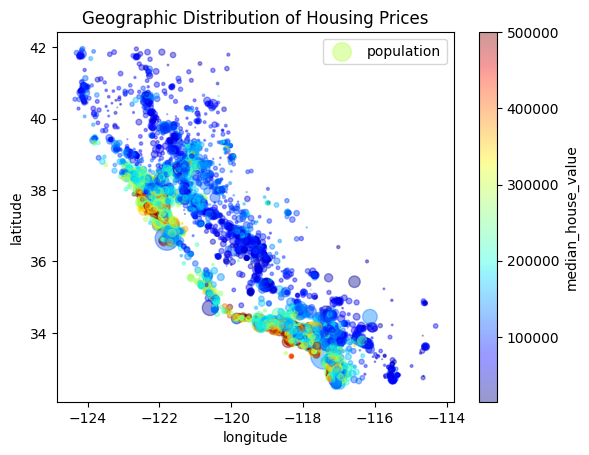

In [111]:
plt.figure(figsize=(10,7))
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population",
             c="median_house_value", cmap="jet", colorbar=True)
plt.legend()
plt.title("Geographic Distribution of Housing Prices")
plt.savefig(IMAGES_DIR / "geo_scatter.png", dpi=300)
plt.show()


# Correlation Analysis

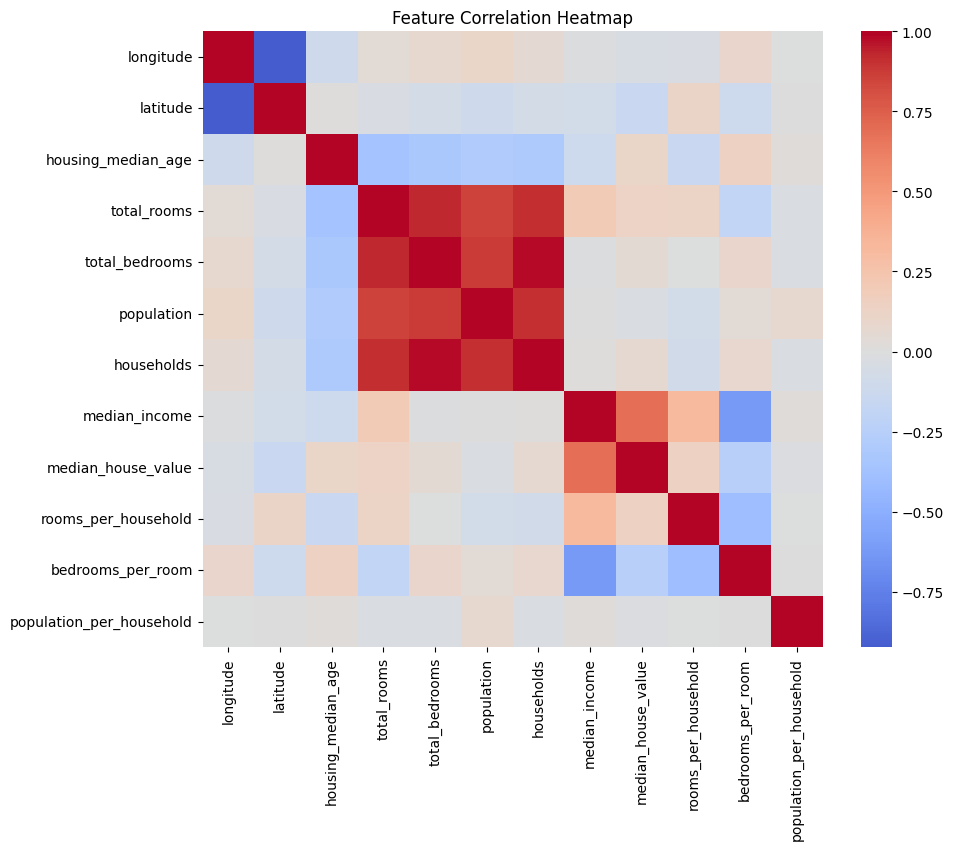

Top correlations with median_house_value:
median_house_value          1.000000
median_income               0.687013
rooms_per_household         0.146940
total_rooms                 0.134060
housing_median_age          0.104714
households                  0.065798
total_bedrooms              0.049993
population_per_household   -0.021577
population                 -0.025820
longitude                  -0.043603
latitude                   -0.146324
bedrooms_per_room          -0.254817
Name: median_house_value, dtype: float64


In [114]:
# Correlation matrix
corr_matrix = housing.corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")

# Save image
plt.savefig(IMAGES_DIR / "correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

print("Top correlations with median_house_value:")
print(corr_matrix["median_house_value"].sort_values(ascending=False))


# Feature Engineering

In [115]:
housing_fe = housing.copy()

# Basic engineered features
housing_fe["rooms_per_household"] = housing_fe["total_rooms"] / housing_fe["households"]
housing_fe["bedrooms_per_room"] = housing_fe["total_bedrooms"] / housing_fe["total_rooms"]
housing_fe["population_per_household"] = housing_fe["population"] / housing_fe["households"]

# Additional engineered/log features
housing_fe["log_median_income"] = np.log(housing_fe["median_income"] + 1)
housing_fe["log_population"] = np.log(housing_fe["population"] + 1)
housing_fe["rooms_per_person"] = housing_fe["total_rooms"] / (housing_fe["population"] + 1)
housing_fe["bedrooms_per_person"] = housing_fe["total_bedrooms"] / (housing_fe["population"] + 1)
housing_fe["income_per_room"] = housing_fe["median_income"] / (housing_fe["total_rooms"] + 1)
housing_fe["population_per_bedroom"] = housing_fe["population"] / (housing_fe["total_bedrooms"] + 1)
housing_fe["age_income_ratio"] = housing_fe["housing_median_age"] / (housing_fe["median_income"] + 1)

# One-hot encode ocean_proximity
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
housing_cat_1hot = cat_encoder.fit_transform(housing_fe[["ocean_proximity"]])

# Build DataFrame with one-hot columns
cat_cols = list(cat_encoder.get_feature_names_out(["ocean_proximity"]))
housing_cat_df = pd.DataFrame(housing_cat_1hot, columns=cat_cols, index=housing_fe.index)

# Merge
housing_final = pd.concat([housing_fe.drop("ocean_proximity", axis=1), housing_cat_df], axis=1)

print("Processed dataset shape:", housing_final.shape)
housing_final.head()


Processed dataset shape: (16512, 24)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,...,rooms_per_person,bedrooms_per_person,income_per_room,population_per_bedroom,age_income_ratio,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878,291000.0,5.597948,...,2.260264,0.418456,0.000764,2.386691,6.084684,0.0,0.0,0.0,0.0,1.0
1,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,156100.0,5.395210,...,1.288984,0.233190,0.005172,4.256098,1.765287,0.0,0.0,0.0,0.0,1.0
2,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875,353900.0,4.655660,...,2.322353,0.522353,0.000534,1.912540,5.973333,0.0,0.0,0.0,1.0,0.0
3,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663,241200.0,6.186154,...,1.845342,0.290959,0.001285,3.429921,4.054295,1.0,0.0,0.0,0.0,0.0
4,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688,53800.0,10.000000,...,3.750000,0.718750,0.006095,1.340426,3.240441,0.0,1.0,0.0,0.0,0.0


# Save Processed Training Set

In [117]:
# Save processed dataset
housing_final.to_csv(PROCESSED_PATH, index=False)
print(f"Processed training set saved: {PROCESSED_PATH} (shape={housing_final.shape})")


Processed training set saved: /Users/sukainaalkhalidy/Desktop/CMSE492/ca_housing_project/data/train/housing_train_processed.csv (shape=(16512, 24))


## Summary
- Visualized housing data geographically
- Explored correlations with the target variable
- Engineered ratio, log, and per-person features
- One-hot encoded `ocean_proximity`
- Final processed training set contains ~24 features
- Saved to `/data/train/housing_train_processed.csv`
